## Electrical Element Detector ##

First, I want to make using tensorflow an image classifier that seperates different electrical elements. After that, I plan to use the model in different applications. 
So, let's begin


So first, I will install my libraries that I will be using. It is important to note that I am using a virtual environment as I am using several versions of Python on my laptop and I will find it easy to depict with certainty the python and pip I am using with a virtual environment


In [7]:
!pip install opencv-python tensorflow matplotlib

In [8]:
!pip install --upgrade pip

In [3]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import cv2
import Augmentor as aug


elements = [Resistor,Voltage Source,Current Source,Inductor, Capacitor,Dependent Voltage Source,Dependent Current Source,Ground,Operational Amplifiers,Diode, Bipolar Junction Transistor,Field Effect Transistor]

In [9]:
elements = ['R','vs','is','L','C','dvs','dis','gnd','opamp','diode','bjt','mosfet']

In [4]:
os.path.join('data','R')
os.path.join('data','vs')


'data/vs'

In [5]:
for element in elements: 
    directory = os.path.join('data',element)
    if not os.path.exists(directory):
        os.mkdir(directory)


NameError: name 'elements' is not defined

First, my thinking here is to augment the data by performing some rotations and also to add more symbols. 


In [12]:
!pip install augmentor

In [6]:
import Augmentor as aug

Declare an augmentation pipeline

In [274]:
image_pipeline = aug.Pipeline("data/R")

Initialised with 10 image(s) found.
Output directory set to data/R/output.

So, I'll add this at the top of the tensorflow pipeline

I defined a function in case I require more classes. 

In [15]:
def ImagePipeline(filename,image_number):
    image_pipeline = aug.Pipeline(filename)
    image_pipeline.rotate(probability=0.7,max_left_rotation=12.5,max_right_rotation=12.5)
    image_pipeline.random_color(probability=0.5,min_factor=0.3,max_factor=.7)
    image_pipeline.flip_random(probability=0.5)
    image_pipeline.random_distortion(probability=0.5,grid_height=6,grid_width=6,magnitude=5)
    image_pipeline.scale(probability=0.2,scale_factor=2)
    image_pipeline.scale(probability=0.2,scale_factor=3)

    image_pipeline.rotate180(probability=0.5)
    image_pipeline.rotate270(probability=0.5)
    image_pipeline.rotate90(probability=0.5)
    image_pipeline.sample(image_number)

    image_pipeline.process()
   
    
    
    

So, after gettig the images of a category, I ran it through the pipeline

In [16]:
for element in elements:
    ImagePipeline(os.path.join('data',element),10000)

Initialised with 29 image(s) found.
Output directory set to data/R/output.

Processing <PIL.Image.Image image mode=RGBA size=3650x1732 at 0x7FD88DE4DE50>: 100%|██████████| 1/1 [00:01<00:00,  1.67s/ Samples]
Processing <PIL.Image.Image image mode=RGBA size=2478x1428 at 0x7FD87363A1F0>:   3%|▎         | 1/29 [00:02<01:13,  2.63s/ Samples]

Found 120738 files belonging to 12 classes.


2022-06-10 06:06:03.544550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 128 of 400
2022-06-10 06:06:11.266480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


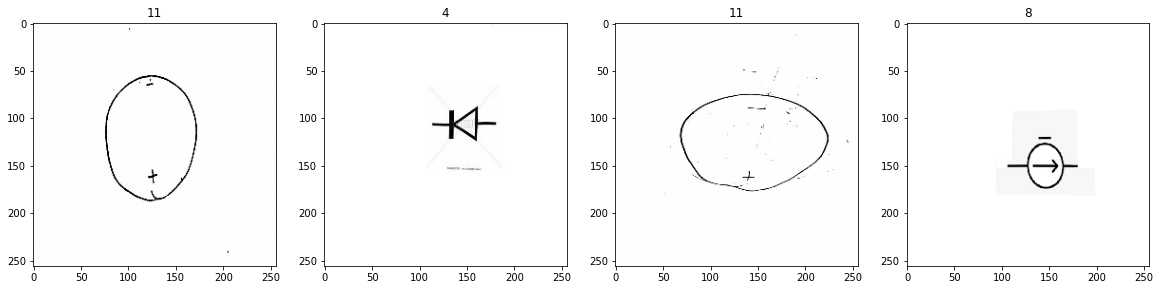

In [651]:
data = tf.keras.utils.image_dataset_from_directory('data',batch_size=50)

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


In [652]:
data = data.map(lambda x, y :(x/255,y))


In [653]:
len(data)

2415

In [654]:
train_size=1455
test_size=480
val_size=480

In [655]:

len(data)== (train_size+test_size+val_size)

True

In [656]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


## Deep Learning Model ##

In [2]:
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16

In [659]:
vgg16_model = VGG16(pooling='avg',weights='imagenet',include_top=False,input_shape=(256,256,3))
for layers in vgg16_model.layers:
    layers.trainable = False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)

vgg_x = Dense(256, activation = 'relu')(vgg_x)
vgg_x = Dense(12, activation = 'softmax')(vgg_x)

vgg16_final_model = tf.keras.Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['acc'])



In [660]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",mode="min",patience=0,restore_best_weights=True,verbose=1)
hist = vgg16_final_model.fit(train,epochs=10,validation_data=val,callbacks=[tensorboard_callback,earlystopping])



Epoch 1/10


2022-06-10 06:07:22.050740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 254 of 400
2022-06-10 06:07:24.796133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


  23/1455 [..............................] - ETA: 3:12:14 - loss: 2.4209 - acc: 0.1713

2022-06-10 06:10:34.270553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 262/1455 [====>.........................] - ETA: 2:39:21 - loss: 1.6311 - acc: 0.5199

2022-06-10 06:42:28.614372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 340/1455 [======>.......................] - ETA: 2:28:24 - loss: 1.4808 - acc: 0.5678

2022-06-10 06:52:44.891041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 496/1455 [=========>....................] - ETA: 2:06:51 - loss: 1.2679 - acc: 0.6333

2022-06-10 07:13:05.713563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 752/1455 [==============>...............] - ETA: 1:32:28 - loss: 1.0507 - acc: 0.6977

2022-06-10 07:46:24.315855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 976/1455 [===================>..........] - ETA: 1:02:56 - loss: 0.9188 - acc: 0.7359

2022-06-10 08:15:43.111231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1311/1455 [==========================>...] - ETA: 18:53 - loss: 0.7832 - acc: 0.7755

2022-06-10 08:59:29.472701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1455/1455 [==============================] - ETA: 0s - loss: 0.7388 - acc: 0.7879

2022-06-10 09:18:25.333211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 335 of 400
2022-06-10 09:18:26.188325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-06-10 09:19:09.845297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 09:24:07.607473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 09:25:51.200898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 09:29:12.729196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 09:34:53.523795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 09:39:56.714950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 09:47:20.123010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cH

1455/1455 [==============================] - 17166s 12s/step - loss: 0.7388 - acc: 0.7879 - val_loss: 0.3077 - val_acc: 0.9197
Epoch 2/10


2022-06-10 10:53:27.105437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 335 of 400
2022-06-10 10:53:28.057871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


  23/1455 [..............................] - ETA: 3:08:29 - loss: 0.3240 - acc: 0.9104

2022-06-10 10:56:33.545300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 262/1455 [====>.........................] - ETA: 2:38:43 - loss: 0.2966 - acc: 0.9206

2022-06-10 11:28:22.905283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 340/1455 [======>.......................] - ETA: 2:29:03 - loss: 0.2886 - acc: 0.9229

2022-06-10 11:38:59.481525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 496/1455 [=========>....................] - ETA: 2:11:10 - loss: 0.2761 - acc: 0.9260

2022-06-10 12:01:22.170376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 752/1455 [==============>...............] - ETA: 1:39:27 - loss: 0.2621 - acc: 0.9305

2022-06-10 12:39:55.209194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


 976/1455 [===================>..........] - ETA: 1:07:51 - loss: 0.2479 - acc: 0.9347

2022-06-10 13:11:46.232374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1311/1455 [==========================>...] - ETA: 20:36 - loss: 0.2318 - acc: 0.9388

2022-06-10 14:01:06.370493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1455/1455 [==============================] - ETA: 0s - loss: 0.2262 - acc: 0.9403

2022-06-10 14:23:49.770058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 239 of 400
2022-06-10 14:23:52.707471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-06-10 14:24:41.110850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 14:30:06.267126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 14:31:57.989964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 14:35:33.124789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 14:41:35.139956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 14:46:49.541905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-10 14:54:32.379421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cH

Restoring model weights from the end of the best epoch: 2.
1455/1455 [==============================] - 18719s 13s/step - loss: 0.2262 - acc: 0.9403 - val_loss: 0.1692 - val_acc: 0.9525
Epoch 2: early stopping


Okay, after this, I have decided to start thinking up the other sets of data that I would need

In [4]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='red',label='loss')
plt.plot(hist.history['val_loss'],color='blue',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'plt' is not defined

In [662]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='red',label='accuracy')

plt.plot(hist.history['val_accuracy'],color='blue',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

KeyError: 'accuracy'

<Figure size 432x288 with 0 Axes>

In [299]:
precision = Precision()
recall = Recall()
acc = BinaryAccuracy()

In [67]:
for batch in test.as_numpy_iterator():
    X, y = batch

    yhat = np.argmax(vgg16_final_model.predict(np.array(X)))
   

 

2022-06-02 23:21:58.158644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities
2022-06-02 23:22:52.231976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid chromaticities


1/1 [==============================] - 4s 4s/step


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [ ]:
c_m = confusion_matrix(y,yhat) #c_m stands for confusion matrix

print(c_m)
sns.heatmap(c_m,cmap = "Reds",annot = True,cbar_kws={"orientation":"vertical","label":"color bar "},xticklabels=[0,1],yticklabels=[0,1],fmt ='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [61]:
print(precision.result().numpy(), recall.result().numpy(), acc.result().numpy())

0.0 0.0 0.0


In [7]:
import cv2

## Saving the model ##

In [8]:
from tensorflow.keras.models import load_model
#vgg16_final_model.save(os.path.join('models','multiimageclassifier3.h5'))






In [9]:
new_model = load_model('models/multiimageclassifier2.h5')
model2 = load_model('models/multiimageclassifier.h5')
final_model = load_model('models/multiimageclassifier3.h5')


2022-06-15 21:14:23.185014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [386]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 391ms/step


array([[2.1501009e-03, 4.1288708e-06, 3.3259806e-03, 4.0520267e-03,
        9.7333860e-01, 8.7285629e-03, 2.9677789e-05, 7.1067450e-04,
        4.6828398e-05, 7.5968797e-03, 1.6506601e-05, 1.1020931e-09]],
      dtype=float32)

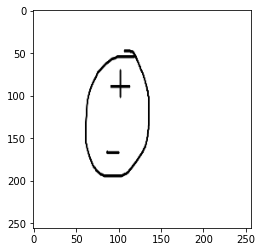

1/1 [==============================] - 0s 243ms/step
Voltage Source


In [10]:
img = cv2.imread('vs55.png')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

image_class =np.argmax(new_model.predict(np.expand_dims(resize/255, 0)))
image_class2 =np.argmax(model2.predict(np.expand_dims(resize/255, 0)))
image_class_final =np.argmax(final_model.predict(np.expand_dims(resize/255, 0)))

added_image_class =np.argmax(0.4*(model2.predict(np.expand_dims(resize/255, 0)))+(0.6*new_model.predict(np.expand_dims(resize/255, 0))))



def numbers_to_label(argument):
    
    switcher = {
        0: "Capacitor",
        1: "Inductor",
        2: "Resistor",
        3: "BJT",
        4: "Diode",
        5: "Dependent Current Source",
        6: "Dependent Voltage Source",
        7: "Ground",
        8: "Current Source",
        9: "MOSFET",
        10: "OP-AMP",
        11: "Voltage Source"

    }
      # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(argument, "nothing")

#print(numbers_to_label(image_class))
#print(numbers_to_label(image_class2))
print(numbers_to_label(image_class_final))


